In [9]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from models.MaskInference import MaskInference
from utils import utils, data, viz
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "~/.nussl/tutorial/train"
val_folder = "~/.nussl/tutorial/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

In [5]:
nf = stft_params.window_length // 2 + 1
model = MaskInference.build(nf, 1, 50, 1, True, 0.0, 1, 'sigmoid')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

In [6]:
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

In [7]:
# Create the engines
trainer, validator = nussl.ml.train.create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)

# We'll save the output relative to this notebook.
output_folder = Path('Tutorial Notebooks').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
    optimizer, train_data, trainer, val_dataloader, validator)

In [8]:
trainer.run(
    train_dataloader, 
    epoch_length=10, 
    max_epochs=1
)

04/26/2023 01:58:01 PM | engine.py:874 Engine run starting with max_epochs=1.
04/26/2023 01:59:12 PM | engine.py:874 Engine run starting with max_epochs=1.
04/26/2023 01:59:19 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:00:07.189
04/26/2023 01:59:19 PM | engine.py:988 Engine run complete. Time taken: 00:00:07.411
04/26/2023 01:59:19 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000755 
- Validation loss: 0.000642 
- Epoch took: 0:01:17.992155 
- Time since start: 0:01:17.992243 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /SFS/user/ry/stonekev/audio/audio_isolation/checkpoints/best.model.pth. 
Output @ /SFS/user/ry/stonekev/audio/audio_isolation 

04/26/2023 01:59:19 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:17.815
04/26/2023 01:59:19 PM | engine.py:988 Engine run complete. Time taken: 00:01:17.995


State:
	iteration: 10
	epoch: 1
	epoch_length: 10
	max_epochs: 1
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /SFS/user/ry/stonekev/audio/audio_isolation/checkpoints/best.model.pth
	output_folder: <class 'pathlib.PosixPath'>

In [10]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=DEVICE,
)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


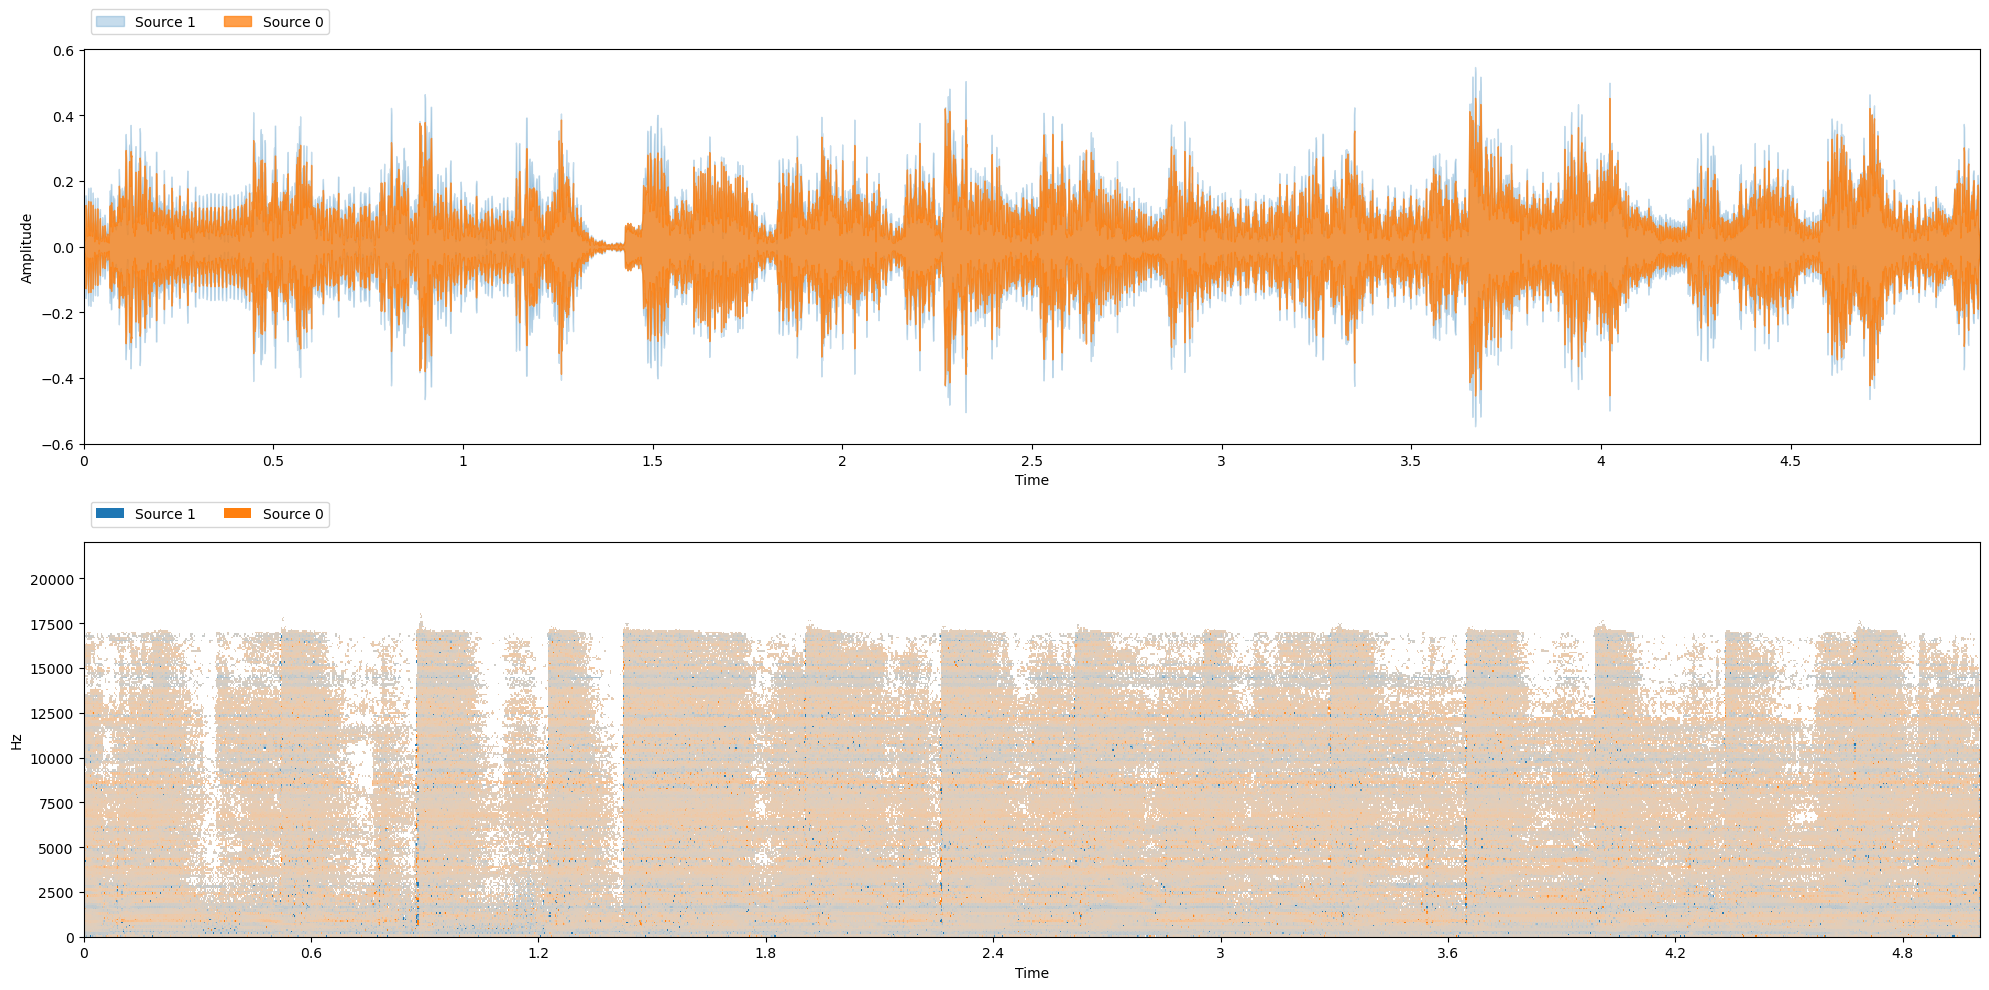


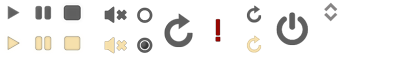
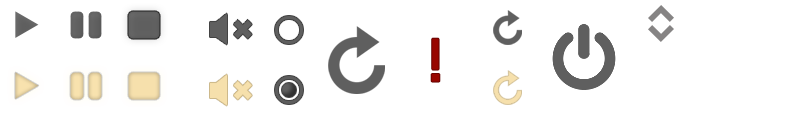
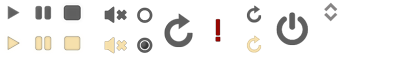

In [11]:
test_folder = "~/.nussl/tutorial/test/"
test_data = data.mixer(stft_params, transform=None, 
    fg_path=test_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
item = test_data[0]

separator.audio_signal = item['mix']
estimates = separator()
# Since our model only returns one source, let's tack on the
# residual (which should be accompaniment)
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)